# MNIST-pytorch

## Principe :

Choix du Jeu de Données et du Modèle
- problème de classification relativement simple :
- Jeu de données MNIST (classification de chiffres manuscrits) et classification multiclasse (les 26 lettres)
- Modèle de réseau de neurones convolutif (CNN) relativement simple

## Architecture du Modèle

Un réseau de neurones simple avec une couche cachée
Utilise nn.Sequential pour définir l'architecture
Transformation des images en vecteurs plats


Fonctions Principales

- train_model() : Gère l'entraînement sur plusieurs époques
- evaluate_model() : Calcule la précision sur le jeu de test
- main() : Orchestre le chargement des données, l'entraînement et l'évaluation


Particularités

- Utilisation de DataLoader pour le chargement des données
- Normalisation des images
- Sauvegarde du modèle entraîné

Résultats Attendus

- Précision autour de 95-97% sur MNIST
- Temps d'entraînement court (quelques minutes)


## Installation des librairies

In [3]:
!pip install torch torchvision matplotlib

## Import des librairies

Permettant de :
- Utiliser les fonctionnalités de base de PyTorch
- Importer des modules pour les réseaux de neurones
- Charger des jeux de données (MNIST)
- Faire des transformations sur les données
- Créer des chargeurs de données

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim


## Définition du Modèle

Cette classe définit l'architecture du réseau de neurones
- input_size=784 (28x28 pixels aplatis)
- hidden_size=128 : couche cachée de 128 neurones
- num_classes=10 : 10 classes pour les chiffres de 0 à 9
- nn.Sequential crée un empilement de couches
- nn.Linear : couches de neurones
- nn.ReLU() : fonction d'activation
- forward() : méthode qui définit la propagation avant, aplatit l'image

In [5]:
class MNISTClassifier(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(MNISTClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        # Aplatir l'image d'entrée
        x = x.view(x.size(0), -1)
        return self.model(x)

## Définition de la fonction d'entrainement

Étapes de l'entraînement :

- Parcourir les époques
- Pour chaque lot de données :
  - Réinitialiser les gradients
  - Faire une prédiction (propagation avant)
  - Calculer l'erreur
  - Calculer les gradients (rétropropagation)
  - Mettre à jour les poids du réseau

In [6]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Réinitialiser les gradients
            optimizer.zero_grad()
            
            # Propagation avant
            output = model(data)
            
            # Calcul de la perte
            loss = criterion(output, target)
            
            # Rétropropagation
            loss.backward()
            
            # Mise à jour des poids
            optimizer.step()
            
            total_loss += loss.item()
        
        # Affichage des statistiques par époque
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

## Fonction d'Évaluation

- Mode évaluation (`model.eval()`)
- `with torch.no_grad()` : pas de calcul de gradient
- Compter les prédictions correctes
- Calculer la précision globale

Fonction Principale

In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

## Fonctions de visualisation

### Visualisation des Datasets

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(dataset, num_samples=10):
    """
    Visualisation d'un échantillon aléatoire d'images du dataset
    Montre l'image et son label
    """
    plt.figure(figsize=(15, 3))
    
    # Sélectionner un échantillon aléatoire
    indices = np.random.randint(0, len(dataset), num_samples)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Convertir le tenseur en image numpy
        img = image.squeeze().numpy()
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### Distribution des classes

In [9]:
def analyze_dataset_distribution(dataset):
    """
    Crée un graphique à barres montrant la distribution des classes
    Permet de vérifier l'équilibre du dataset
    """
    labels = [label for _, label in dataset]
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 5))
    plt.bar(unique, counts)
    plt.title('Distribution des Classes')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(unique)
    
    # Afficher le nombre exact
    for i, count in enumerate(counts):
        plt.text(unique[i], count, str(count), ha='center', va='bottom')
    
    plt.show()

### Fonction d'analyse détaillée

In [10]:
def detailed_model_evaluation(model, test_loader):
    """
    Évaluation détaillée avec matrice de confusion et exemples de prédictions
    - Crée une matrice de confusion
    - Visualise les images mal classées
    - Montre où le modèle fait des erreurs
    La matrice de confusion montre où le modèle confond des classes
    Les images mal classées aident à comprendre les limites du modèle
    """
    model.eval()
    
    # Matrices pour stocker les résultats
    confusion_matrix = np.zeros((10, 10), dtype=int)
    misclassified_images = []
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            # Matrice de confusion
            for t, p in zip(target, predicted):
                confusion_matrix[t.item(), p.item()] += 1
            
            # Collecter les images mal classées
            mask = predicted != target
            for img, true_label, pred_label in zip(data[mask], target[mask], predicted[mask]):
                misclassified_images.append((img, true_label.item(), pred_label.item()))
    
    # Visualiser la matrice de confusion
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
    plt.title('Matrice de Confusion')
    plt.colorbar()
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    
    # Ajouter les valeurs dans la matrice
    for i in range(10):
        for j in range(10):
            plt.text(j, i, str(confusion_matrix[i, j]), 
                     horizontalalignment="center", 
                     verticalalignment="center")
    
    plt.tight_layout()
    plt.show()

# Utilisation du modèle

## Chargement et préparation des données

- Préparer les transformations de données
    - `transforms.Normalize((0.1307,), (0.3081,))` : normalisation des images
- Charger les datasets d'entraînement et de test
    - `batch_size=64` : traiter 64 images à la fois
- Créer des DataLoaders
    - `root='./data'` : chemin pour stocker les données
    - `transform=transform` : fonction de transformation des données (ici normalisation)
    - `train=` : `True` pour les données d'entrainement, et `False` pour les données de test

In [12]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Transformations des données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Chargement des données
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Chargement des données de test
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Préparation des loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Visualisation des données

### Visualisation des échantillons d'entraînement 

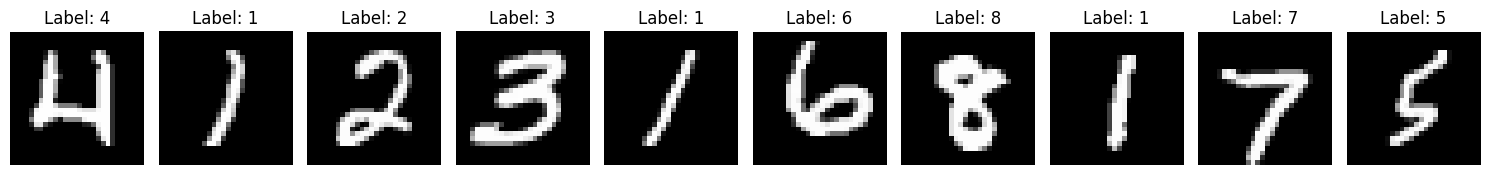

In [13]:
visualize_dataset(train_dataset)

### Visualisation des échantillons de test :

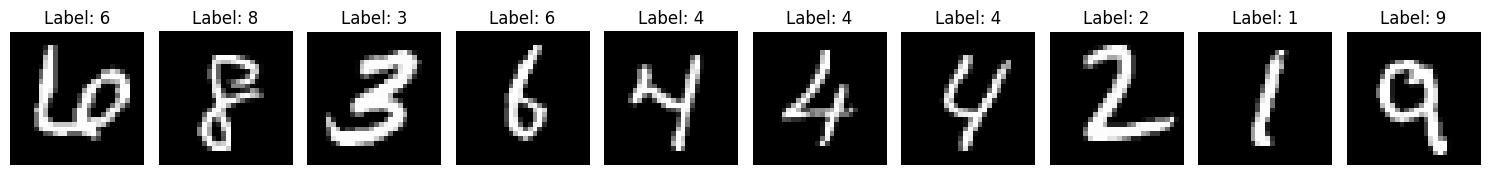

In [14]:
visualize_dataset(test_dataset)

### Distribution des classes

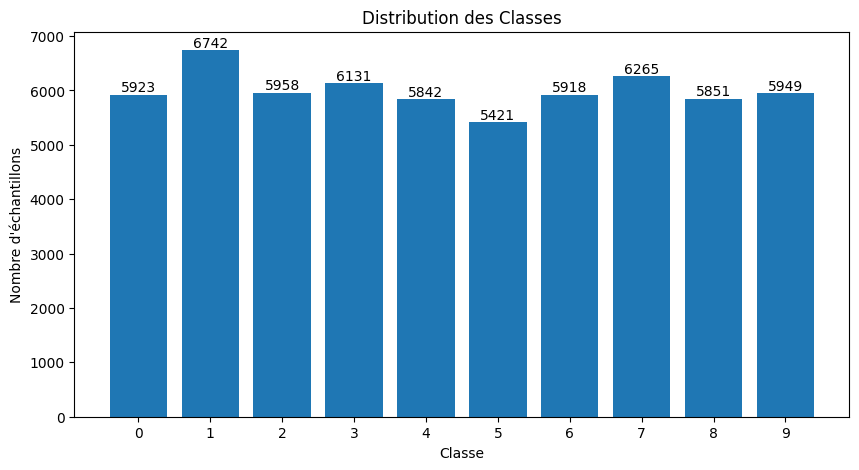

In [15]:
analyze_dataset_distribution(train_dataset)

## Entrainement du modèle

- Initialiser le modèle : appel de la classe `MNISTClassifier`
- Définir la fonction de perte (Cross-Entropy)
  - `nn.CrossEntropyLoss()` : adapté à la classification multiclasse
- Choisir un optimiseur (Adam)
  - `optim.Adam` :
  - `lr=0.001` : taux d'apprentissage
- Entraîner le modèle
  
 
  

In [22]:
def training_example(model):
  """
  Initialisation
  Loss function
  Training
  """
  # Définition de la fonction de perte et de l'optimiseur
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Entraînement du modèle
  train_model(model, train_loader, criterion, optimizer)

# Initialisation du modèle
model = MNISTClassifier()

# Entrainement
training_example(model)


Epoch [1/5], Loss: 0.2609
Epoch [2/5], Loss: 0.1167
Epoch [3/5], Loss: 0.0801
Epoch [4/5], Loss: 0.0599
Epoch [5/5], Loss: 0.0468


## Evaluation du modèle

### Précision du modèle

Précision attendue autour de 95-97% 


In [23]:
evaluate_model(model, test_loader)

Test Accuracy: 97.58%


### Analyse détaillée des performances 

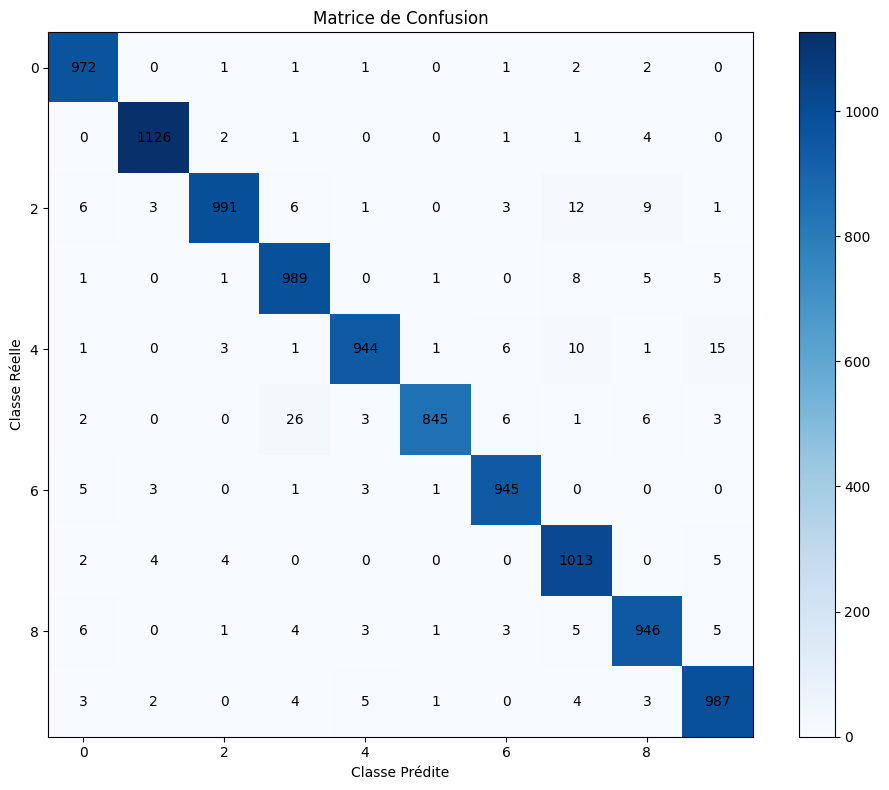

In [24]:
confusion_mat = detailed_model_evaluation(model, test_loader)

## Sauvegarde du modèle et inférence

### Sauvegarde des Poids et paramètres du modèle

- sauvegarde dans `mnist_classifier.pth` dans le répertoire courant
- `state_dict()` ne sauvegarde que les poids et paramètres
- Méthode recommandée car plus légère et flexible

In [25]:
def save_model(model, path='mnist_classifier.pth'):
    # Sauvegarde des paramètres
    torch.save(model.state_dict(), path)

save_model(model)


In [26]:
!ls *.pth

mnist_classifier.pth


## Chargement des poids et Inférence

- Charge un batch de données de test
- Fait des prédictions
- Visualise les résultats avec les prédictions et les vraies étiquettes

In [29]:
def load_model(path='mnist_classifier.pth'):
    """
    Crée une nouvelle instance du modèle avec la même architecture
    - load_state_dict() charge les poids sauvegardés
    - model.eval() passe le modèle en mode inference
    """
    # Créer une instance du modèle
    model = MNISTClassifier()
    
    # Charger les poids
    model.load_state_dict(torch.load(path))
    
    # Mettre en mode évaluation
    model.eval()
    
    return model

def inference_example(model, test_dataset):
    """
    Charge un batch de données de test
    Fait des prédictions
    Visualise les résultats avec les prédictions et les vraies étiquettes
    """
    # Chargement des données
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    
    with torch.no_grad():
        # Faire des prédictions
        images, labels = next(iter(test_loader))
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Visualisation des résultats
        plt.figure(figsize=(15, 3))
        for i in range(10):
            plt.subplot(1, 10, i+1)
            plt.imshow(images[i].squeeze().numpy(), cmap='gray')
            plt.title(f'Prédit: {predicted[i]}\nRéel: {labels[i]}', fontsize=8)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

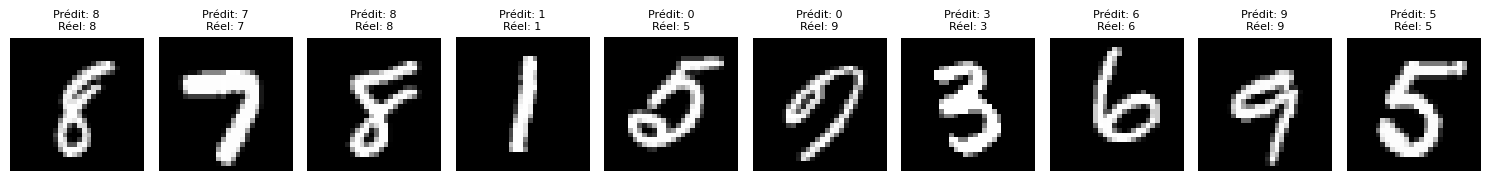

In [30]:
# Chargement du modèle sauvegardé
loaded_model = load_model()
    
# Exemple d'inférence
inference_example(loaded_model, test_dataset)